In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3  # Import InceptionV3
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import metrics
from keras.utils import to_categorical
import os

In [2]:
# Define the image size
SIZE = 256  

# Path to the dataset
dataset_path = "F:/indhu/Datasets/Tomato fruits dataset for binary and multiclass classification/Two Classes"
print(os.listdir(dataset_path))

['Healthy', 'Reject']


In [3]:
# Capture images and labels into respective lists
images = []
labels = []
for directory_path in glob.glob(dataset_path + "/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        images.append(img)
        labels.append(label)

In [4]:
# Convert lists to arrays        
images = np.array(images)
labels = np.array(labels)

In [5]:

# Encode labels from text to integers
le = preprocessing.LabelEncoder()
labels_encoded = le.fit_transform(labels)

In [6]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)

In [7]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [8]:
# One hot encode y values for neural network (if needed later)
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [9]:
# Load InceptionV3 model without fully connected layers (pretrained on ImageNet)
Inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

In [10]:
# Use the pre-trained InceptionV3 model to extract features from training images
train_features = Inception_model.predict(x_train)
train_features = train_features.reshape(train_features.shape[0], -1)  # Flatten features for SVM

44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 538ms/step


In [11]:
# Extract features from testing images
test_features = Inception_model.predict(x_test)
test_features = test_features.reshape(test_features.shape[0], -1)  # Flatten features for SVM


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 492ms/step


In [12]:
# Train SVM on the extracted features
SVM_model = SVC(kernel='linear', random_state=42)
SVM_model.fit(train_features, y_train)

SVC(kernel='linear', random_state=42)

In [13]:
# Predict on test data using SVM
y_pred = SVM_model.predict(test_features)

In [14]:
# Inverse transform the predicted labels to their original form
y_pred_labels = le.inverse_transform(y_pred)

In [15]:
# Calculate accuracy of the model
accuracy = metrics.accuracy_score(le.inverse_transform(y_test), y_pred_labels)
print("Accuracy = ", accuracy)

Accuracy =  0.9572649572649573


In [38]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

cm = confusion_matrix(le.inverse_transform(y_test), y_pred_labels)
tp, fp, fn, tn = cm.ravel()  # For binary classification
precision = precision_score(le.inverse_transform(y_test), y_pred_labels, average='weighted')
recall = recall_score(le.inverse_transform(y_test), y_pred_labels, average='weighted')
f1 = f1_score(le.inverse_transform(y_test), y_pred_labels, average='weighted')

print(f"Confusion Matrix: \n {cm}\n TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}\n Precision: {precision},\n Recall: {recall}, \n F1 Score: {f1}")


Confusion Matrix: 
 [[315   6]
 [  9  21]]
 TP: 315, TN: 21, FP: 6, FN: 9
 Precision: 0.9556030389363721,
 Recall: 0.9572649572649573, 
 F1 Score: 0.956239734697507


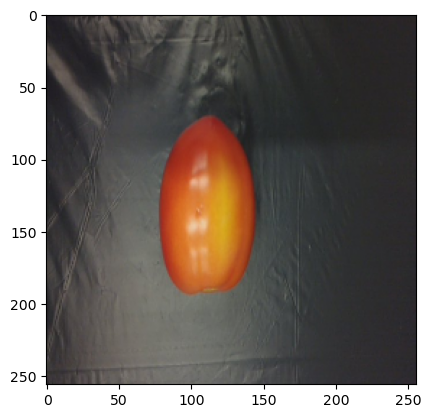

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
The prediction for this image is:  Healthy
The actual label for this image is:  Healthy


In [27]:
# Check results on a few select images
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
plt.show()

# Predict using SVM model for the selected image
input_img = np.expand_dims(img, axis=0)  # Expand dims so the input is (num images, x, y, c)
input_img_feature = Inception_model.predict(input_img)
input_img_feature = input_img_feature.reshape(input_img_feature.shape[0], -1)

prediction_SVM = SVM_model.predict(input_img_feature)[0]
prediction_SVM_label = le.inverse_transform([prediction_SVM])  # Reverse the label encoder to original name

print("The prediction for this image is: ", prediction_SVM_label[0])
print("The actual label for this image is: ", le.inverse_transform([y_test[n]])[0])
